In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime
from math import ceil

## Load data

In [2]:
train_data = pd.read_csv(r'../datasets/train_data.csv')
validation_data = pd.read_csv(r'../datasets/validation_data.csv')
test_data = pd.read_csv(r'../datasets/test_data.csv')

In [3]:
train_data.head()

,CategoryCode,ItemCode,DateID,DailySales
0,category_2,117610,11/6/2021,7
1,category_4,836584,11/18/2021,16
2,category_1,370195,1/24/2022,6
3,category_2,172582,10/30/2021,5
4,category_2,1006009,10/30/2021,5


In [4]:
validation_data.head()

,CategoryCode,ItemCode,Week,WeeklySales
0,category_2,1044502,w1,11
1,category_2,1105009,w1,11
2,category_2,913561,w4,5
3,category_1,1048975,w4,30
4,category_1,17287,w2,60


In [5]:
test_data.head()

,CategoryCode,ItemCode,Week,PredictedSales
0,category_1,43738,w4,NaN
1,category_2,1006090,w1,NaN
2,category_2,1076929,w4,NaN
3,category_1,1081321,w3,NaN
4,category_2,216151,w4,NaN


## Preprocess

In [6]:
category_codes = np.unique([*train_data['CategoryCode'].values, *validation_data['CategoryCode'].values, *test_data['CategoryCode'].values])
category_map = {}

for i in range(len(category_codes)):
    category_map[category_codes[i]] = i

In [7]:
item_codes = np.unique([*train_data['ItemCode'].values, *test_data['ItemCode'].values, *validation_data['ItemCode'].values])
item_map = {}

for i in range(len(item_codes)):
    item_map[item_codes[i]] = i

In [8]:
def string_to_date(d):
    return datetime(int(d.split('/')[2]), int(d.split('/')[0]), int(d.split('/')[1]))

In [9]:
def get_year(date):
    return date.year

def get_month(date):
    return date.month

def get_annual_week_id(date):
    return pd.Period(date).week

def get_monthly_week_id(date):
    first_day = date.replace(day=1)

    dom = date.day
    adjusted_dom = dom + first_day.weekday()

    return int(ceil(adjusted_dom/7.0))

def get_category_id(id):
    return category_map[id]

def get_item_code_id(id):
    return item_map[id]

In [10]:
def week_to_weekid(week):
    if (week == "w1"):
        return get_annual_week_id(('02/14/2022'))
    if (week == "w2"):
        return get_annual_week_id(('02/21/2022'))
    if (week == "w3"):
        return get_annual_week_id(('02/28/2022'))
    if (week == "w4"):
        return get_annual_week_id(('03/07/2022'))

weeks = np.unique(test_data['Week'].values)
week_id_map = {}

for i in range(len(weeks)):
    week_id_map[weeks[i]] = week_to_weekid(weeks[i])

In [11]:
def get_week_id_from_map(week):
    return week_id_map[week]

#### Preprocess train data

In [12]:
train_data['WeekID'] = train_data['DateID'].apply(get_annual_week_id)
train_data['DateID'] = train_data['DateID'].apply(string_to_date)
train_data['DailySales'] = train_data['DailySales']
train_data['Year'] = train_data['DateID'].apply(get_year)
train_data['ItemCode'] = train_data['ItemCode'].apply(get_item_code_id)
train_data['CategoryCode'] = train_data['CategoryCode'].apply(get_category_id)

In [13]:
train_grp_by_week = train_data.groupby(['WeekID', 'CategoryCode', 'ItemCode', 'Year'])['DailySales'].sum().reset_index()
train_grp_by_week = train_grp_by_week.rename(columns = {'DailySales': 'WeeklySales'}, inplace = False)
train_grp_by_week.head()

,WeekID,CategoryCode,ItemCode,Year,WeeklySales
0,1,0,0,2022,83
1,1,0,1,2022,66
2,1,0,5,2022,21
3,1,0,6,2022,621
4,1,0,10,2022,31


In [14]:
train_grp_by_week.describe()

,WeekID,CategoryCode,ItemCode,Year,WeeklySales
count,3952.000000,3952.000000,3952.000000,3952.000000,3952.000000
mean,33.918775,0.919787,95.639676,2021.329200,37.058957
std,19.510868,0.869572,55.659723,0.469982,72.419014
min,1.000000,0.000000,0.000000,2021.000000,1.000000
25%,6.000000,0.000000,47.750000,2021.000000,9.000000
50%,43.000000,1.000000,96.000000,2021.000000,17.000000
75%,48.000000,1.000000,143.000000,2022.000000,36.250000
max,52.000000,3.000000,193.000000,2022.000000,909.000000


#### Preprocess validation data

In [15]:
validation_data['ItemCode'] = validation_data['ItemCode'].apply(get_item_code_id)
validation_data['CategoryCode'] = validation_data['CategoryCode'].apply(get_category_id)

validation_data['WeekID'] = validation_data['Week'].apply(get_week_id_from_map) 

In [16]:
val_data_grp_by_week = validation_data.groupby(['CategoryCode', 'ItemCode', 'WeekID'])['WeeklySales'].sum().reset_index()
val_data_grp_by_week.head()

,CategoryCode,ItemCode,WeekID,WeeklySales
0,0,0,7,25
1,0,0,8,69
2,0,0,9,120
3,0,0,10,69
4,0,1,7,7


In [17]:
val_data_grp_by_week.describe()

,CategoryCode,ItemCode,WeekID,WeeklySales
count,370.000000,370.000000,370.000000,370.000000
mean,0.848649,94.956757,8.516216,42.759459
std,0.774814,55.496364,1.121848,72.832726
min,0.000000,0.000000,7.000000,1.000000
25%,0.000000,50.250000,8.000000,11.000000
50%,1.000000,94.500000,9.000000,22.000000
75%,1.000000,142.000000,10.000000,48.000000
max,3.000000,191.000000,10.000000,771.000000


#### Preprocess test data

In [18]:
test_data['ItemCode'] = test_data['ItemCode'].apply(get_item_code_id)
test_data['CategoryCode'] = test_data['CategoryCode'].apply(get_category_id)

test_data['WeekID'] = test_data['Week'].apply(get_week_id_from_map) 

In [19]:
test_data_grp_by_week = test_data.drop(['Week', 'PredictedSales'], axis='columns')
test_data_grp_by_week.head()

,CategoryCode,ItemCode,WeekID
0,0,27,10
1,1,110,7
2,1,160,10
3,0,167,9
4,1,68,10


## Visualizations

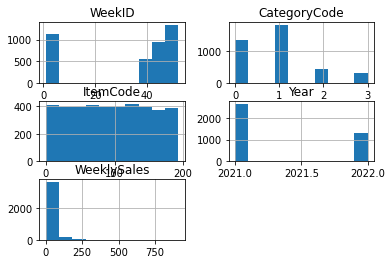

In [20]:
train_grp_by_week.hist()
plt.show()

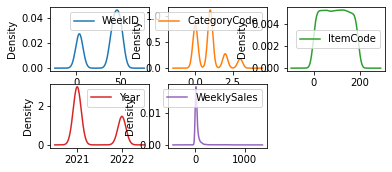

In [21]:
train_grp_by_week.plot(kind='density', subplots=True, sharex=False, layout=(3, 3))
plt.show()

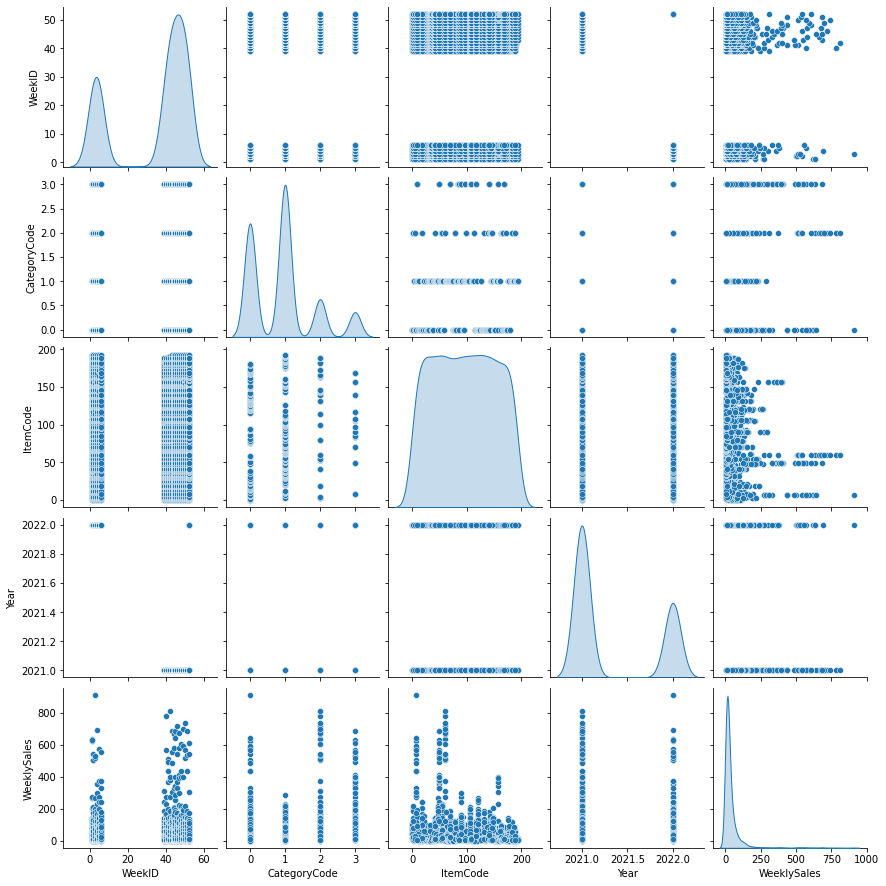

In [22]:
sns.pairplot(data=train_grp_by_week, diag_kind='kde')

[Text(0.5, 1.0, 'Correlation matrix\n')]

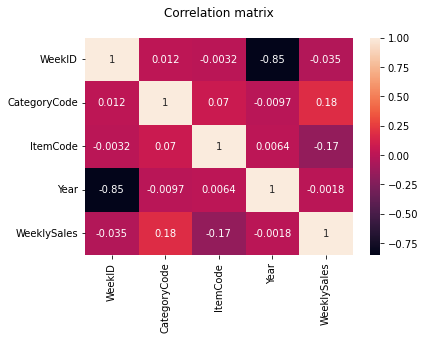

In [23]:
hm = sns.heatmap(train_grp_by_week.corr(), annot = True)
hm.set(title = "Correlation matrix\n")

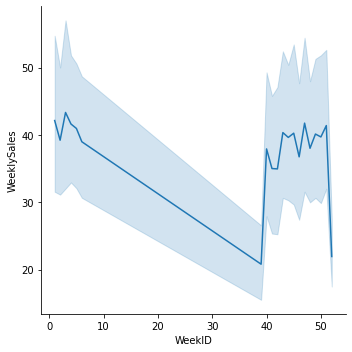

In [24]:
sns.relplot(x=train_grp_by_week['WeekID'], y=train_grp_by_week['WeeklySales'], kind='line')
plt.show()

## Normalize data

In [25]:
from sklearn.preprocessing import Normalizer

In [26]:
def normalize(arr):
    scalar = Normalizer().fit([arr])
    return scalar.transform([arr])[0]

In [27]:
week_values = [*train_grp_by_week['WeekID'].values, *test_data_grp_by_week['WeekID'].values, *val_data_grp_by_week['WeekID'].values]
category_codes = [*train_grp_by_week['CategoryCode'].values, *test_data_grp_by_week['CategoryCode'].values, *val_data_grp_by_week['CategoryCode'].values]
item_codes = [*train_grp_by_week['ItemCode'].values, *test_data_grp_by_week['ItemCode'].values, *val_data_grp_by_week['ItemCode'].values]

In [28]:
normalized_week_ids = normalize(week_values)
normalized_category_codes = normalize(category_codes)
normalized_item_codes = normalize(item_codes)

In [29]:
train_len = len(train_grp_by_week['WeekID'].values)
test_len = len(test_data_grp_by_week['WeekID'].values)
val_len = len(val_data_grp_by_week['CategoryCode'].values)

print(train_len, test_len, val_len)

3952 377 370


In [30]:
train_x = pd.DataFrame()
train_x['week_id_of_year'] = normalized_week_ids[:train_len]
train_x['category_code'] = normalized_category_codes[:train_len]
train_x['item_code'] = normalized_item_codes[:train_len]

train_x.shape

(3952, 3)

In [31]:
test_x = pd.DataFrame()
test_x['week_id_of_year'] = normalized_week_ids[train_len:(test_len + train_len)]
test_x['category_code'] = normalized_category_codes[train_len:(test_len + train_len)]
test_x['item_code'] = normalized_item_codes[train_len:(test_len + train_len)]

test_x.shape

(377, 3)

In [32]:
val_x = pd.DataFrame()
val_x['week_id_of_year'] = normalized_week_ids[(test_len + train_len): ]
val_x['category_code'] = normalized_category_codes[(test_len + train_len): ]
val_x['item_code'] = normalized_item_codes[(test_len + train_len): ]

val_x.shape

(370, 3)

In [33]:
train_y = train_grp_by_week['WeeklySales']
val_y = val_data_grp_by_week['WeeklySales']

In [34]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(train_x, train_y, test_size=0.33, shuffle=True)
print(X_train.shape, Y_train.shape)

(2647, 3) (2647,)


In [36]:
# from imblearn.over_sampling import RandomOverSampler

# def getBalancedData(X, Y):
#     sm = RandomOverSampler(random_state=42)
#     return sm.fit_resample(X, Y)

# balanced_X, balanced_Y = getBalancedData(X_train, Y_train)
# print(balanced_X.shape, balanced_Y.shape)


## Metrics (Explained variance score)

In [37]:
from sklearn.metrics import explained_variance_score

def get_ev_score(true_values, predicted_values):
    return explained_variance_score(true_values, predicted_values)

## Random Forest Regressor

In [38]:
from sklearn.ensemble import RandomForestRegressor
random_forest_reg = RandomForestRegressor()
random_forest_reg.fit(X_train, Y_train)

random_forest_reg.score(X_test, Y_test)
random_forest_predictions = random_forest_reg.predict(X_test)

In [39]:
# uniform avarage score
random_forest_reg.score(val_x, val_y)

0.7533797269603898

In [40]:
# explained variance score
get_ev_score(Y_test, random_forest_predictions)

0.8094689982391076

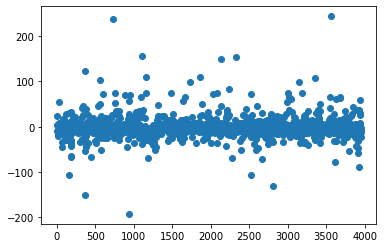

In [41]:
plt.plot(Y_test - random_forest_predictions, marker='o', linestyle='')

## Extra Trees Regressor

In [42]:
from sklearn.ensemble import ExtraTreesRegressor

extra_trees_reg = ExtraTreesRegressor()
extra_trees_reg.fit(X_train, Y_train)

extra_trees_reg.score(X_test, Y_test)
extra_trees_predictions = extra_trees_reg.predict(X_test)

In [43]:
# uniform avarage score
extra_trees_reg.score(val_x, val_y)

0.6817456469897916

In [44]:
# explained variance score
get_ev_score(Y_test, extra_trees_predictions)

0.7780840380788797

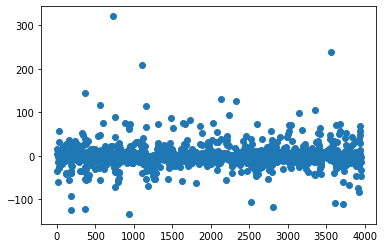

In [45]:

plt.plot(Y_test - extra_trees_predictions, marker='o', linestyle='')

## Voting Regressor

In [46]:
from sklearn.ensemble import VotingRegressor

r1 = RandomForestRegressor(n_estimators=100, random_state=10, criterion='absolute_error')
r2 = RandomForestRegressor(n_estimators=10, random_state=1)

voting_reg = VotingRegressor([('rf', r1), ('et', r2)]).fit(X_train, Y_train)
voting_reg_predictions = voting_reg.predict(X_test)

In [47]:
# uniform avarage score
voting_reg.score(X_test, Y_test)

0.8098608470853448

In [48]:
# explained variance score
get_ev_score(Y_test, voting_reg_predictions)

0.8098638109871412

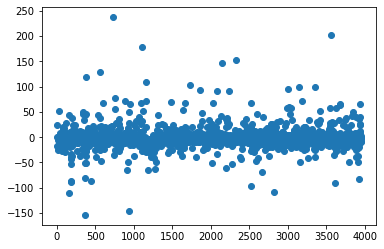

In [49]:
plt.plot(Y_test - voting_reg_predictions, marker='o', linestyle='')

In [53]:

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import QuantileTransformer

#generic function to fit model and return metrics for every algorithm
def boost_models(x):
    #transforming target variable through quantile transformer
    regr_trans = TransformedTargetRegressor(regressor=x, transformer=QuantileTransformer(output_distribution='normal'))
    regr_trans.fit(X_train, Y_train)
    yhat = regr_trans.predict(X_test)
    algoname= x.__class__.__name__
    return algoname, round(np.sqrt(explained_variance_score(Y_test, yhat)),2)

r1 = RandomForestRegressor(n_estimators=100, random_state=10, criterion='absolute_error')
r2 = RandomForestRegressor(n_estimators=10, random_state=1)

vr = VotingRegressor([('rf', r1), ('et', r2)])

algo=[GradientBoostingRegressor(), vr, RandomForestRegressor(), ExtraTreesRegressor()]
score=[]
for a in algo:
    score.append(boost_models(a))

#Collate all scores in a table
pd.DataFrame(score, columns=['Model', 'Score'])

,Model,Score
0,GradientBoostingRegressor,0.70
1,VotingRegressor,0.88
2,RandomForestRegressor,0.87
3,ExtraTreesRegressor,0.86


## Most effective regressior identified (Voting regressor with 2 random forests)

In [ ]:
test_data = pd.read_csv(r'../datasets/test_data.csv')
test_data['PredictedSales'] = voting_reg.predict(test_x)
test_data['PredictedSales'] = test_data['PredictedSales'].apply(lambda val: round(val))
test_data['ItemCode'] = test_data['ItemCode'].apply(lambda val: str(val))

submission_df = pd.DataFrame()
submission_df['ID'] = test_data[['CategoryCode', 'ItemCode', 'Week']].agg(lambda x: '_'.join(x.values), axis=1)
submission_df['WeeklySales'] = test_data['PredictedSales']
submission_df.head()

In [ ]:
submission_df.to_csv('../results/test_predictions.csv', index=False)